# Main

this notebook is the main file of the project, here the model are trained and evaluated

# Import libraies

In [21]:
#coustom modules
from train import Trainer
from models import Generator, Critic
import data.data_preprocessing as data_prep
import utils
from rescale_generated import Rescale

#pytorch modules
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

#general modules
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os

# Create the dataset

The following function transform the data bere using them as input for the model.

In [16]:
#create the transformer to scale the series
class ScaleInput:
    
    def __init__(self, scale) -> None:
        self.scale = scale

    def __call__(self, sample):
        return sample * self.scale

class Magnitude_Scaler:

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):

        cap = torch.max(sample) * self.scale
        bottom = torch.min(sample) * self.scale

        X_std = (sample - bottom) / (cap - bottom)
        X_scaled = X_std * (cap - bottom) + bottom
        
        return X_scaled

the following code create the dataset and plot some sample of the dataset series

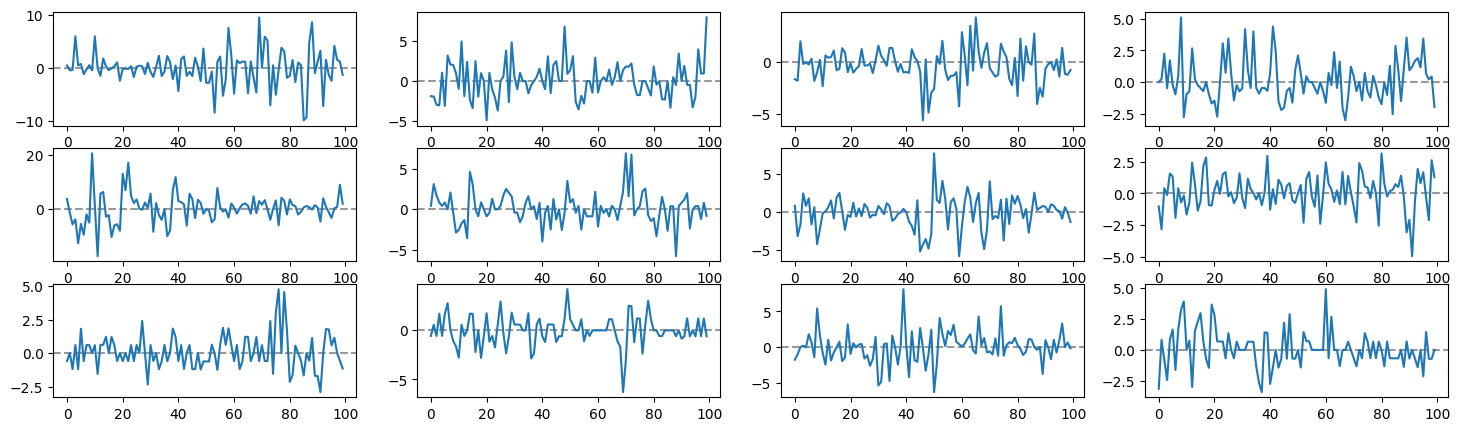

In [23]:
np.random.seed(0)
#initialize the transformer
scaler = ScaleInput(100)
#create the dataset
dataset = data_prep.WindowsDaset(r'data\dataset_100_winds',transform = scaler)
#plot some series
rows = 3
columns = 4
fig, axs = plt.subplots(rows, columns, figsize=(18,5))
for ax, i in zip(axs.ravel(),np.random.randint(0, len(dataset),size=rows * columns)):
    ax.axhline(0, color = 'black', alpha =0.4, ls = '--')
    ax.plot(dataset[i])

# Model initialization and training

the following box of code contains all the hyperparameters for the model training

In [22]:
#chose the Base directiory to save the run
BASE_DIR = r'C:\Users\bolla\Desktop\CUHK_courses\IASP_elisa\runs'

#global variables for the run
GP_WEIGHT = 10
G_NORM_PEN = 5
CRITIC_IT = 5
PRINT_EVERY = 10
CHECKPOINT_FREQ = 10
BATCH_SIZE = 256
LOG_NAME = 'run_1_0'
EPOCHS = 40

run_ARCHIVE = utils.create_dir(BASE_DIR,'000_007')

In [25]:
import importlib
import models
importlib.reload(models)
from models import Generator, Critic

import train
importlib.reload(train)
from train import Trainer

The following is the core of model training:

In [26]:
#create the dataloader
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

# Instantiate Generator and Critic + initialize weights
if False:

    from checkpoints import models as models_test
    state_dicts = torch.load('checkpoints/epoch_39.pkl', map_location=torch.device('cpu'))
    

    g = models_test.Generator()
    g.load_state_dict(state_dicts['g_state_dict'])
    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.05)
    #adam optimizer beta1 = 0.5 beta2 .99 lr = 0.003
    #grater for discriminator the lr


    c = models_test.Critic()
    c.load_state_dict(state_dicts['d_state_dict'])
    c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)
    
g = Generator()
g_opt = torch.optim.Adam(g.parameters(), lr=0.003, betas=[0.5, 0.99])
#g_opt = torch.optim.RMSprop(g.parameters(), lr=0.1)

c = Critic()
c_opt = torch.optim.Adam(c.parameters(), lr=0.009, betas=[0.5, 0.99])
#c_opt = torch.optim.RMSprop(c.parameters(), lr=0.05)

log_name = LOG_NAME
# Instantiate Tensorboard writer
tb_logdir = os.path.join('tensorboard', log_name)
writer = SummaryWriter(log_dir=tb_logdir)

# Instantiate Trainer
trainer = Trainer(g, c, g_opt, c_opt,GP_WEIGHT,G_NORM_PEN,CRITIC_IT,PRINT_EVERY,CHECKPOINT_FREQ, writer=writer, ARCHIVE_DIR=run_ARCHIVE)
# Train model
print('Training is about to start...')

trainer.train(data_loader, epochs=EPOCHS, plot_training_samples=True, checkpoint=None)

Training is about to start...


 28%|██▊       | 11/40 [19:36<48:20, 100.00s/it] 

In [ ]:
importlib.reload(utils)

# Evaluate the model

the following code rescale use the model to generate samples of returns and plot the results

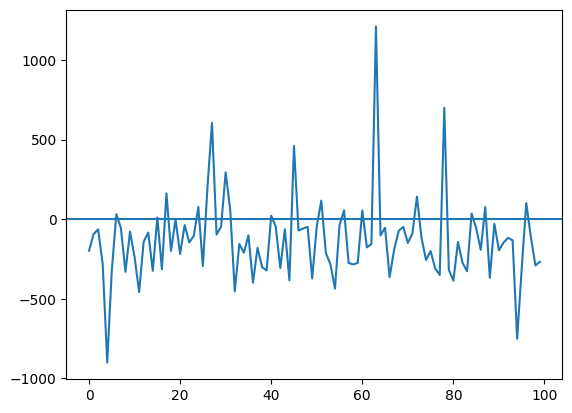

In [355]:
#generate samples
sample = utils.generate_sample(g)

#create a non-transformed dataset to initialize the rescaler
plain_dataset = data_prep.WindowsDaset(r'data\dataset_100_winds')
#initialize the rescaler
rescaler = Rescale(plain_dataset)

#scale the generated series
for i in range(len(sample)):
    sample[i] = rescaler.scale(sample[i])

In [ ]:
fig, axs = plt.subplots(len(sample)/2, 2)
fig.facecolor('white')

i = 0
for samp in sample:
    axs[i].plot(samp)
    axs[i].axhline(0, ls ='--', color = 'black')
    axs[i].set_title(f'mean: {sample.mean()} | sd: {sample.std()}')
    
    generated_price = []
    
    init = 1
    for p in samp:
        init = init + init * p.item()
        generated_price.append(init)
    
    axs[i+1].plot(generated_price)
    axs[i+1].set_title('Prices')

    i += 2